<a href="https://colab.research.google.com/github/AndreySmirdin/DeepUnsupervisedLearning/blob/hw_2/Task5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import datetime
import pickle
import os
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
from sklearn.model_selection import train_test_split
from scipy.stats import norm
from tqdm.auto import tqdm
from google.colab import drive

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

In [2]:
drive.mount('/content/drive')

mnist_path = '/content/drive/My Drive/Colab Notebooks/hw2_q2.pkl'

with open(mnist_path, 'rb') as f:
    dataset = pickle.load(f)

train_data = dataset['train']
test_data = dataset['test']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


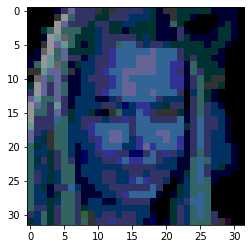

In [3]:
plt.imshow(train_data[1] * 50);

In [0]:
batch_size = 64
num_epochs = 20
lr = 0.0001

def process_data(data):
    return torch.tensor(data.transpose(0, 3, 1, 2))

train_loader = torch.utils.data.DataLoader(process_data(train_data), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(process_data(test_data), batch_size=batch_size, shuffle=False) 

In [0]:
class ResBlock(nn.Module):
    def __init__(self, n_filters):
        super().__init__()

        self.n_filters = n_filters
        self.model = nn.Sequential(
            nn.Conv2d(self.n_filters, self.n_filters, 1),
            nn.ReLU(),
            nn.Conv2d(self.n_filters, self.n_filters, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(self.n_filters, self.n_filters, 1),
        )

    def forward(self, x):
        return x + self.model(x)

class AffineCoupling(nn.Module):
    def __init__(self, n_in, n_filters=256, n_blocks=8):
        super().__init__()

        self.n_filters = n_filters
        self.n_blocks = n_blocks

        self.n_in = n_in
        self.n_out = self.n_in * 2

        self.first_conv = nn.Conv2d(self.n_in, self.n_filters, 3, padding=1)
        self.layers = nn.Sequential(*[ResBlock(self.n_filters) for _ in range(n_blocks)])
        self.relu = nn.ReLU()
        self.final_conv = nn.Conv2d(self.n_filters, self.n_out, 3, padding=1)


    def forward(self, x):
        x1, x2 = x
        y1 = x1
        s, t = torch.chunk(self.simple_resnet(x1), 2, dim=1)
        # y2 = torch.exp(log_s) * (y1 + t)
        y2 = torch.exp(s) * x2 + t
        return (y1, y2), s.sum(dim=(1, 2, 3)).abs()

    def reverse(self, z):
        z1, z2 = z
        x1 = z1
        s, t = torch.chunk(self.simple_resnet(z1), 2, dim=1)
        x2 = z2 * torch.exp(-s) - t
        return (x1, x2)

    def simple_resnet(self, x):
        z = self.first_conv(x)
        z = self.layers(z)
        z = self.relu(z)
        z = self.final_conv(z)
        return z

class RealNvp(nn.Module):
    def __init__(self, n_in=3):
        super().__init__()

        self.coupling1 = nn.ModuleList([AffineCoupling(n_in) for _ in range(4)])
        self.coupling2 = nn.ModuleList([AffineCoupling(n_in * 2) for _ in range(3)])
        self.coupling3 = nn.ModuleList([AffineCoupling(n_in * 4) for _ in range(3)])
        self.coupling4 = nn.ModuleList([AffineCoupling(n_in * 8) for _ in range(3)])
        self.coupling5 = nn.ModuleList([AffineCoupling(n_in * 16) for _ in range(3)])

    def step(self, x1, x2, layers):
        N = x1.shape[0]
        total_det = torch.zeros(N).to(device)
        for layer in layers:
            (x1, x2), det = layer((x1, x2))
            x1, x2 = x2, x1
            total_det += det

        return (x1, x2), total_det

    def reverse_step(self, x1, x2, layers):
        for layer in reversed(layers):
            x1, x2 = x2, x1 # is it correct?????
            x1, x2 = layer.reverse((x1, x2))
        return x1, x2

    def checkboard_step(self, x, layers):
        x1, x2 = self.checkboard_split(x)
        
        (x1, x2), det = self.step(x1, x2, layers)

        x = self.inverse_checkboard_split(x1, x2)
        return x, det

    def reverse_checkboard_step(self, x, layers):
        x1, x2 = self.checkboard_split(x)
        (x1, x2) = self.reverse_step(x1, x2, layers)
        x = self.inverse_checkboard_split(x1, x2)
        return x

    def channel_step(self, x, layers):
        x = self.squeeze(x)
        x1, x2 = self.channel_split(x)
        
        (x1, x2), det = self.step(x1, x2, layers)

        x = self.inverse_channel_split(x1, x2)
        return x, det

    def reverse_channel_step(self, x, layers):
        x1, x2 = self.channel_split(x)
        x1, x2 = self.reverse_step(x1, x2, layers)
        x = self.inverse_channel_split(x1, x2)
        x = self.reverse_squeeze(x)
        return x

    def forward(self, x):
        x = x.float() / 3
        x, det1 = self.checkboard_step(x, self.coupling1)
        x, det2 = self.channel_step(x, self.coupling2)
        x, det3 = self.checkboard_step(x, self.coupling3)
        x, det4 = self.channel_step(x, self.coupling4)
        x, det5 = self.checkboard_step(x, self.coupling5)
        return x, sum([det1, det2, det3, det4, det5])

    def reverse(self, z):
        z = self.reverse_checkboard_step(z, self.coupling5)
        z = self.reverse_channel_step(z, self.coupling4)
        z = self.reverse_checkboard_step(z, self.coupling3)
        z = self.reverse_channel_step(z, self.coupling2)
        z = self.reverse_checkboard_step(z, self.coupling1)
        return z

    def checkboard_split(self, x):
        N, C, H, W = x.shape
        mask = torch.from_numpy(np.indices((H, W)).sum(axis=0) % 2 == 0).repeat(N, C, 1, 1)
        return x[mask].reshape(N, C, H, W // 2), x[~mask].reshape(N, C, H, W // 2)
    
    def inverse_checkboard_split(self, x1, x2):
        N, C, H, W = x1.shape
        mask = torch.from_numpy(np.indices((H, W * 2)).sum(axis=0) % 2 == 0)
        res = torch.zeros(N, C, H, W * 2).to(device)
        res[:, :, mask] = x1.reshape(N, C, -1)
        res[:, :, ~mask] = x2.reshape(N, C, -1)
        return res

    def squeeze(self, x):
        N, C, H, W = x.shape
        mask1 = torch.tensor([True, False, False, False]).reshape(2, 2).repeat(N, C, H // 2, W // 2)
        mask2 = torch.tensor([False, True, False, False]).reshape(2, 2).repeat(N, C, H // 2, W // 2)
        mask3 = torch.tensor([False, False, True, False]).reshape(2, 2).repeat(N, C, H // 2, W // 2)
        mask4 = torch.tensor([False, False, False, True]).reshape(2, 2).repeat(N, C, H // 2, W // 2)

        x1 = x[mask1].reshape(N, C, H // 2, W // 2)
        x2 = x[mask2].reshape(N, C, H // 2, W // 2)
        x3 = x[mask3].reshape(N, C, H // 2, W // 2)
        x4 = x[mask4].reshape(N, C, H // 2, W // 2)
        return torch.cat([x1, x2, x3, x4], dim=1)

    def reverse_squeeze(self, x):
        N, C, H, W = x.shape
        mask1 = torch.tensor([True, False, False, False]).reshape(2, 2).repeat(N, C // 4, H, W)
        mask2 = torch.tensor([False, True, False, False]).reshape(2, 2).repeat(N, C // 4, H, W)
        mask3 = torch.tensor([False, False, True, False]).reshape(2, 2).repeat(N, C // 4, H, W)
        mask4 = torch.tensor([False, False, False, True]).reshape(2, 2).repeat(N, C // 4, H, W)

        res = torch.zeros(N, C // 4, H * 2, W * 2).to(device)
        x1, x2, x3, x4 = torch.chunk(x, 4, dim=1)
        res[mask1] = x1.reshape(-1)
        res[mask2] = x2.reshape(-1)
        res[mask3] = x3.reshape(-1)
        res[mask4] = x4.reshape(-1)
        return res

    
    def channel_split(self, x):
        return torch.chunk(x, 2, dim=1)
    
    def inverse_channel_split(self, x1, x2):
        return torch.cat([x1, x2], dim=1)

normal = torch.distributions.normal.Normal(torch.tensor(0.), torch.tensor(1.))
def get_loss(x, det):
    probs = normal.log_prob(x).sum(dim=(1, 2, 3))
    return (-probs + det).mean()

def sample(model, n=10):
    x = model.reverse(normal.sample((n, 48, 8, 8)).to(device))
    return x

In [18]:
# Testing corectness
N, C, W, H = 1, 3, 32, 32
model = RealNvp().to(device)
x = torch.rand(N * C * W * H).reshape(N, C, W, H).float().to(device)
z, _ = model(x)
x_ = model.reverse(z)
print((x - x_).sum())

tensor(1033.2263, device='cuda:0', grad_fn=<SumBackward0>)


In [0]:
path = '/content/drive/My Drive/Colab Notebooks/'

def load_model(model, num):
    model.load_state_dict(torch.load(os.path.join(path, f'celebs{num}.data')))
    model.eval()
    return model
               

def train(model, optim, train_loader, test_loader, num_epochs, continue_train=True):
    state_path = os.path.join(path, 'state.pkl')
    
    if continue_train and os.path.exists(state_path):
        with open(state_path, 'rb') as f:
            state_dict = pickle.load(f)
        print(state_dict)
        losses = state_dict['loss']
        val_losses = state_dict['val_losses']
        start = state_dict['epoch']
        model = load_model(model, start)
        start += 1
        
    else:
        losses, val_losses = [], []
        start = 0

    print(f"Resumed training after {start} epochs")

    for epoch in tqdm(range(start, num_epochs)):
        loss, val_loss = 0, 0
        for batch in tqdm(train_loader):
            batch = batch.to(device)
            optim.zero_grad()
            z, det = model(batch)
            cur_loss = get_loss(z, det)
            loss += cur_loss.item()
            cur_loss.backward()
            optim.step()
        
        with torch.no_grad():
            for batch in test_loader:
                batch = batch.to(device)
                z, det = model(batch)
                val_loss += get_loss(z, det).item()
                
        loss /= len(train_loader)
        val_loss /= len(test_loader)
        losses.append(loss)
        val_losses.append(val_loss)

        print(f'After epoch {epoch} train loss is {loss} valiidation loss is {val_loss}')

        with open(state_path, 'wb') as f:
            pickle.dump({
                'loss': losses,
                'val_losses': val_losses,
                'epoch': epoch
            }, f)
        torch.save(model.state_dict(), os.path.join(path, f'celebs{epoch}.data'))
    
    return losses, val_losses

In [0]:
torch.cuda.empty_cache()
model = RealNvp().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train(model, optimizer, train_loader, test_loader, num_epochs)

{'loss': [2931.4847689010085, 2873.206784769369, 2863.391126541284], 'val_losses': [[...], [...], [...]], 'epoch': 2}
Resumed training after 3 epochs


After epoch 3 train loss is 2890.719342021516 valiidation loss is 2863.7165960864486


After epoch 4 train loss is 2858.202859019319 valiidation loss is 2854.971111547167


After epoch 5 train loss is 2851.159923809405 valiidation loss is 2850.153865635952


After epoch 6 train loss is 2848.6627045165237 valiidation loss is 2846.837945385514


After epoch 7 train loss is 2845.778830433806 valiidation loss is 2844.3365649642233


After epoch 8 train loss is 2843.8187423559802 valiidation loss is 2843.438777745327


After epoch 9 train loss is 2842.16610922524 valiidation loss is 2843.1419734776578


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([10, 48, 8, 8])
torch.Size([10, 12, 16, 16])


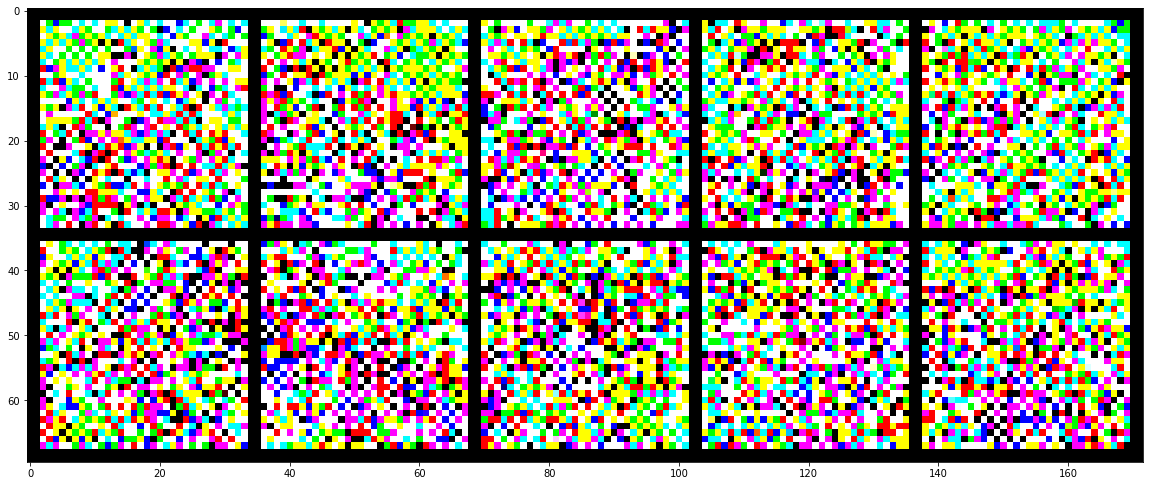

In [12]:
def imshow(img):
    npimg = img.cpu().detach().numpy()
    plt.figure(figsize=[20, 20])
    plt.imshow(np.transpose(npimg, (1, 2, 0)) * 50)
    plt.show()

celebs = RealNvp().to(device)
celebs = load_model(celebs, 8)

grid = torchvision.utils.make_grid(sample(celebs), nrow=5)
imshow(grid)